In [52]:
import numpy as np
import random

def generate_data_stream(length=1000, anomaly_chance=0.05):
    time = np.arange(length) # Map each index in an array to a moment in time i.e each index in an array can be thought of as nth moment in time
    # print(time)
    seasonal_pattern = np.sin(2 * np.pi * time / 100) #After 100 time steps, the seasonal pattern will repeat
    # The use of np.si() ensures that the seasonal pattern is periodic and will repeat after 100 time steps

    # print(seasonal_pattern)
    noise = np.random.normal(0, 0.2, size=length) #Introduce some noise to the data

    # print(noise)
    
    data_stream = seasonal_pattern + noise #Create a data stream that is a combination of the seasonal pattern and the noise

    
    # Add anomalies
    for i in range(length):#Checking over the entire data stream to see if an anomaly will be injected there
        if random.random() < anomaly_chance: #If some random number is less than the anomaly chance, input an anomaly into our data stream
            data_stream[i] += random.uniform(2, 5)  # Inject anomalies
    # print (data_stream)
    return data_stream



In [53]:
from collections import deque
import numpy as np

def ema(data_point, previous_ema, alpha):
    #Exponential Moving Average, alpha is the smoothing factor
    #Alpha determines how heavily we want to weigh more recent data points versus older data
    #The higher the alpha , the more heavily we weigh recent data points

    return alpha * data_point + (1 - alpha) * previous_ema

def detect_anomalies(data_stream, window_size=50, threshold=2, alpha=1):
    if not data_stream.any():
        raise ValueError("Data stream was empty")
    
    if not isinstance(window_size, int) or window_size <= 0:
        raise ValueError("Window size must be a positive integer")
    
    if threshold <= 0:
        raise ValueError("Threshold must be a positive number")
    
    if alpha <= 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    
    
    data_stream = [float(x) for x in data_stream if isinstance(x, (int, float))]
    
    if len(data_stream) < window_size:
        raise ValueError(f"Data stream length ({len(data_stream)}) is less than window size ({window_size})")
    anomalies = []
    rolling_window = deque(maxlen=window_size) #A rolling window takes a set amount of list items, for each iteration we will remove the first item in the window and add the next item in the list
    #This will allow us to detect if the most recently added data point is the anomaly
    ema_value = data_stream[0]  # Initialize EMA with first data point
    
    
    for i, data_point in enumerate(data_stream):
        ema_value = ema(data_point, ema_value, alpha)  #Calculate the EMA for the current data point
        rolling_window.append(data_point)   #Add the current data point to the rolling window

        
        # Calculate mean and std for the available window even if < window_size, to avoid an anomaly being in the first 50  data points

        mean = np.mean(rolling_window)   #Calculate the mean of the current window
        std = np.std(rolling_window) #Calculate the standard deviation of the current window
        
        # Avoid division by zero (in case std is zero)
        if std == 0 or std == float('inf'):
            std = 1
        
        z_score = (ema_value - mean) / std  #Calculate the z-score of the current EMA value

        # Check if the z-score exceeds the threshold
        if abs(z_score) > threshold:
            anomalies.append((i, data_point))   #Add the index and value of the anomaly to the list of anomalies if it exceeds the threshold

    
    return anomalies



In [ ]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def generate_data_stream(length=1000, anomaly_chance=0.01):
    time = np.arange(length)
    seasonal_pattern = np.sin(2 * np.pi * time / 100)
    noise = np.random.normal(0, 0.2, size=length)
    data_stream = seasonal_pattern + noise

    for i in range(length):
        if random.random()< anomaly_chance:
            data_stream[i] += random.uniform(2, 5)  # Inject anomalies
        yield data_stream[i]

class AnomalyDetector:
    def __init__(self, window_size=50, threshold=2, alpha=0.1):
        self.window_size = window_size
        self.threshold = threshold
        self.alpha = alpha
        self.rolling_window = deque(maxlen=window_size)
        self.ema_value = None

    def process_point(self, data_point):
        if self.ema_value is None:
            self.ema_value = data_point
        
        self.ema_value = self.alpha * data_point + (1 - self.alpha) * self.ema_value
        self.rolling_window.append(data_point)

        if len(self.rolling_window) < self.window_size:
            return False        
        
        print(len(self.rolling_window))

        mean = np.mean(self.rolling_window)
        std = np.std(self.rolling_window)
        
        if std == 0 or np.isinf(std):
            std = 1
            
        z_score = (self.ema_value - mean) / std
        print(f"EMA: {self.ema_value}, Mean: {mean}, Std: {std}, Z-score: {abs(z_score)}, Threshold:{self.threshold}")  # Debugging prints
        return abs(z_score) > self.threshold

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))
line, = ax.plot([], [], lw=2, label='Data Stream')
anomaly_scatter, = ax.plot([], [], 'ro', markersize=8, label='Anomalies')
ax.set_xlim(0, 200)
ax.set_ylim(-7, 7)
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Real-time Anomaly Detection')
ax.legend()

# Initialize data
x_data, y_data = [], []
anomaly_x, anomaly_y = [], []

# Create instances of generator and detector
data_generator = generate_data_stream(length=1000, anomaly_chance=0.05)
detector = AnomalyDetector()

def update(frame):
    global x_data, y_data, anomaly_x, anomaly_y
    
    # Get new data point
    new_y = next(data_generator)
    x_data.append(frame)
    y_data.append(new_y)
    
    # Detect anomaly
    is_anomaly = detector.process_point(new_y)
    if is_anomaly:
        anomaly_x.append(frame)
        anomaly_y.append(new_y)
        print(f"Anomaly detected at point {frame}: {new_y}")
    
    # Update plot data
    line.set_data(x_data, y_data)
    anomaly_scatter.set_data(anomaly_x, anomaly_y)
    
    # Adjust x-axis limit for scrolling effect
    if frame > 200:
        ax.set_xlim(frame - 200, frame)
    
    return line, anomaly_scatter

# Create animation
ani = FuncAnimation(fig, update, frames=range(1000), blit=True, interval=50)

plt.show()

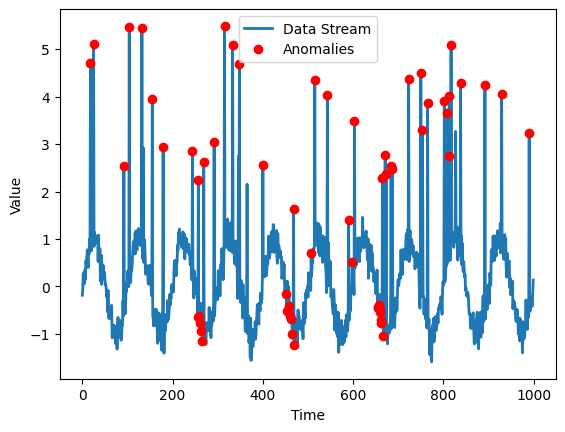

60


In [54]:
import matplotlib.pyplot as plt

def plot_data_with_anomalies(data_stream, anomalies):
    fig, ax = plt.subplots()
    
    # Plot the entire data stream
    ax.plot(range(len(data_stream)), data_stream, lw=2, label='Data Stream')
    
    # Plot the anomalies as red dots
    if anomalies:
        anomaly_indices = [idx for idx, _ in anomalies]
        anomaly_values = [data_stream[idx] for idx in anomaly_indices]
        ax.plot(anomaly_indices, anomaly_values, 'ro', label='Anomalies')
    
    # Add labels and legend
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    plt.legend()
    plt.show()

# Example usage:
data_stream = generate_data_stream()
anomalies = detect_anomalies(data_stream)
if anomalies == [] :
    print("No anomalies detected")
    exit()
plot_data_with_anomalies(data_stream, anomalies)
print(len(anomalies))